# ChemBERTa + Conformal Prediction (v5)
**Objective:** Reliable, coverage-guaranteed multi-label toxicity predictions robust to scaffold shift, with efficient (small) prediction sets.


## 1: setup 

In [8]:
# --- Cell 1: Environment & paths (v5 setup) ---

import os, json, random, numpy as np, torch
from pathlib import Path

# Repro
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Paths
ROOT = Path("tox21_chemberta_v5")
DATA = ROOT / "data"
DESC = DATA / "descriptors"
SPLITS = DATA / "splits"
MODEL = ROOT / "model"
CKPTS = MODEL / "checkpoints"  # we’ll still read from MODEL/ if not here
CPDIR = ROOT / "cp"
CAL = CPDIR / "calibrators"
RES = CPDIR / "results"
PLOTS = ROOT / "plots"
LOGS = ROOT / "logs"
for d in [DATA, DESC, SPLITS, MODEL, CKPTS, CPDIR, CAL, RES, PLOTS, LOGS]:
    d.mkdir(parents=True, exist_ok=True)

# If your config.json lives directly in MODEL/, snapshot it for provenance
cfg_src = MODEL / "config.json"
cfg_dst = MODEL / "config_v4_snapshot.json"
if cfg_src.exists() and not cfg_dst.exists():
    cfg_dst.write_text(cfg_src.read_text())

# Quick inventory so we know what’s present
expected = [
    SPLITS/"splits.json",
    DATA/"y.npy",
    DATA/"y_mask.npy",
    DATA/"X_smiles.txt",
    DATA/"label_names.txt",
    DESC/"desc_selected.npy",
    DESC/"desc_standardizer.pkl",
]
present = [str(p) for p in expected if p.exists()]
missing = [str(p) for p in expected if not p.exists()]

print("Present:", *present, sep="\n  ")
print("\nMissing (if any):", *missing, sep="\n  ")
print("\nCheckpoint candidates in model/:")
for name in ["best_model_tuned.pt", "best_model.pt", "last_model.pt"]:
    p = MODEL / name
    if p.exists(): print("  ", p.name)
print("\nDone setup.")


Present:
  tox21_chemberta_v5\data\splits\splits.json
  tox21_chemberta_v5\data\y.npy
  tox21_chemberta_v5\data\y_mask.npy
  tox21_chemberta_v5\data\X_smiles.txt
  tox21_chemberta_v5\data\label_names.txt
  tox21_chemberta_v5\data\descriptors\desc_selected.npy
  tox21_chemberta_v5\data\descriptors\desc_standardizer.pkl

Missing (if any):

Checkpoint candidates in model/:

Done setup.


## 2: Load data & splits; quick diagnostics

In [9]:
# --- Cell 2: Load data & splits; quick diagnostics ---

import json, numpy as np
from pathlib import Path

# Use paths from Cell 1: DATA, DESC, SPLITS
y = np.load(DATA/"y.npy")                 # (N, L)
y_mask = np.load(DATA/"y_mask.npy")       # (N, L)  1=label present
smiles = (DATA/"X_smiles.txt").read_text(encoding="utf-8").splitlines()
label_names = (DATA/"label_names.txt").read_text(encoding="utf-8").splitlines()
L = len(label_names)

splits = json.loads((SPLITS/"splits.json").read_text())
train_idx = np.array(splits["train"], dtype=int)
val_idx   = np.array(splits["val"], dtype=int)
test_idx  = np.array(splits["test"], dtype=int)

X_desc = np.load(DESC/"desc_selected.npy")  # (N, D_desc)

print(f"N={len(smiles)}, L={L}, desc_dim={X_desc.shape[1]}")
print(f"Splits train/val/test = {len(train_idx)}/{len(val_idx)}/{len(test_idx)}")
print("Label prevalence (train):")
prev = (y[train_idx]==1).sum(axis=0) / np.maximum((y_mask[train_idx]==1).sum(axis=0), 1)
for name, p in zip(label_names, prev):
    print(f"  {name:6s}: {p:.3f}")


N=7831, L=12, desc_dim=256
Splits train/val/test = 6265/783/783
Label prevalence (train):
  NR-AR : 0.045
  NR-AR-LBD: 0.039
  NR-AhR: 0.120
  NR-Aromatase: 0.050
  NR-ER : 0.133
  NR-ER-LBD: 0.054
  NR-PPAR-gamma: 0.027
  SR-ARE: 0.156
  SR-ATAD5: 0.037
  SR-HSE: 0.056
  SR-MMP: 0.161
  SR-p53: 0.057


## 3: Model def & load tuned checkpoint (inference mode)

In [12]:
# --- Cell 3 (patched): Model def + checkpoint key translation ---

import torch, torch.nn as nn
from transformers import AutoConfig, AutoTokenizer, AutoModel
import json
from pathlib import Path

# Load config snapshot if present
cfg_v4_path = MODEL / "config_v4_snapshot.json"
if cfg_v4_path.exists():
    CONFIG = json.loads(cfg_v4_path.read_text())
else:
    CONFIG = {
        "base_model_name": "DeepChem/ChemBERTa-100M-MLM",
        "max_length": 256,
        "pooling": "mean",
        "desc_dim_in": int(X_desc.shape[1]),
        "fusion_hidden": 512,
        "dropout": 0.15,
    }

base_model = CONFIG.get("base_model_name", "DeepChem/ChemBERTa-100M-MLM")
pooling = CONFIG.get("pooling", "mean")
dropout = float(CONFIG.get("dropout", 0.15))
fusion_hidden = int(CONFIG.get("fusion_hidden", 512))
desc_dim_in = int(CONFIG.get("desc_dim_in", X_desc.shape[1]))
L = len(label_names)

# Tokenizer
local_tok_dir = MODEL / "tokenizer"
tok = AutoTokenizer.from_pretrained(str(local_tok_dir) if local_tok_dir.exists() else base_model)
_ = AutoConfig.from_pretrained(base_model)

class FusionHead(nn.Module):
    def __init__(self, h_dim, d_dim, out_dim, dropout=0.15, hidden=512):
        super().__init__()
        self.desc = nn.Sequential(
            nn.Linear(d_dim, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
        )
        self.fuse = nn.Sequential(
            nn.Linear(h_dim + 256, hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, out_dim),
        )
    def forward(self, h_tok, x_desc):
        d = self.desc(x_desc)
        z = torch.cat([h_tok, d], dim=-1)
        return self.fuse(z)

class ChemBERTaFusion(nn.Module):
    def __init__(self, base_model_name, pooling="mean", out_dim=L, dropout=0.15, fusion_hidden=512):
        super().__init__()
        self.enc = AutoModel.from_pretrained(base_model_name)
        self.pooling = pooling
        self.dropout = nn.Dropout(dropout)
        self.head = FusionHead(self.enc.config.hidden_size, desc_dim_in, out_dim, dropout=dropout, hidden=fusion_hidden)

    def forward(self, input_ids, attention_mask, x_desc):
        out = self.enc(input_ids=input_ids, attention_mask=attention_mask)
        if self.pooling == "mean":
            mask = attention_mask.unsqueeze(-1)
            h = (out.last_hidden_state * mask).sum(1) / mask.sum(1).clamp(min=1e-6)
        else:
            h = out.last_hidden_state[:, 0, :]
        h = self.dropout(h)
        logits = self.head(h, x_desc)
        return logits

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ChemBERTaFusion(
    base_model_name=base_model,
    pooling=pooling,
    out_dim=L,
    dropout=dropout,
    fusion_hidden=fusion_hidden,
).to(device)

# ---- Checkpoint load with key translation ----
ckpt_candidates = [MODEL/"best_model_tuned.pt", MODEL/"best_model.pt", MODEL/"last_model.pt"]
ckpt_path = next((p for p in ckpt_candidates if p.exists()), None)
assert ckpt_path is not None, "No checkpoint file found in tox21_chemberta_v5/model/."

state = torch.load(ckpt_path, map_location=device)
raw_sd = state.get("model_state", state.get("state_dict", state))

def translate_keys(sd: dict) -> dict:
    out = {}
    for k, v in sd.items():
        # strip DataParallel prefix
        if k.startswith("module."):
            k = k[len("module."):]
        # skip training-only extras
        if k.startswith("focal.") or k == "pos_weight":
            continue
        # encoder -> enc
        if k.startswith("encoder."):
            k = "enc." + k[len("encoder."):]
        # desc_mlp -> head.desc
        if k.startswith("desc_mlp."):
            k = "head.desc." + k[len("desc_mlp."):]
        # fusion -> head.fuse
        if k.startswith("fusion."):
            k = "head.fuse." + k[len("fusion."):]
        # optional: pooler mismatch is fine; keep if present
        out[k] = v
    return out

state_dict = translate_keys(raw_sd)
missing, unexpected = model.load_state_dict(state_dict, strict=False)
model.eval()

print(f"Loaded checkpoint: {ckpt_path.name}")
print(f"Pooling='{pooling}', fusion_hidden={fusion_hidden}, desc_dim_in={desc_dim_in}, out_dim={L}")
print("Device:", device)
print("Missing keys:", missing)
print("Unexpected keys:", unexpected)


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-100M-MLM and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded checkpoint: best_model_tuned.pt
Pooling='mean', fusion_hidden=512, desc_dim_in=256, out_dim=12
Device: cuda
Missing keys: []
Unexpected keys: []


## 4: Dataloaders 

In [13]:
from torch.utils.data import Dataset, DataLoader
import torch
import numpy as np

class ToxDataset(Dataset):
    def __init__(self, idx):
        self.idx = np.asarray(idx, dtype=int)
    def __len__(self): 
        return len(self.idx)
    def __getitem__(self, i):
        j = self.idx[i]
        return {
            "smiles": smiles[j],
            "desc": X_desc[j].astype(np.float32),
            "y": y[j].astype(np.float32),
            "mask": y_mask[j].astype(np.float32),
        }

def collate(batch):
    toks = tok(
        [b["smiles"] for b in batch],
        padding=True,
        truncation=True,
        max_length=int(CONFIG.get("max_length", 256)),
        return_tensors="pt",
    )
    desc = torch.tensor(np.stack([b["desc"] for b in batch]), dtype=torch.float32)
    yb   = torch.tensor(np.stack([b["y"]    for b in batch]), dtype=torch.float32)
    mb   = torch.tensor(np.stack([b["mask"] for b in batch]), dtype=torch.float32)
    return {**toks, "desc": desc, "y": yb, "mask": mb}

def make_loader(idx, bs=64, shuffle=False):
    return DataLoader(ToxDataset(idx), batch_size=bs, shuffle=shuffle, num_workers=0, collate_fn=collate)

val_loader  = make_loader(val_idx, bs=64, shuffle=False)
test_loader = make_loader(test_idx, bs=64, shuffle=False)

print("Val batches:", len(val_loader))
print("Test batches:", len(test_loader))


Val batches: 13
Test batches: 13


## 5: Baseline logits & probabilities

In [14]:
import numpy as np
import torch
from tqdm.auto import tqdm

@torch.no_grad()
def collect_logits(dloader, model, device):
    logits_list, mask_list, y_list = [], [], []
    model.eval()
    for b in tqdm(dloader, desc="Infer"):
        ids = b["input_ids"].to(device)
        att = b["attention_mask"].to(device)
        dsc = b["desc"].to(device)
        out = model(ids, att, dsc)
        logits_list.append(out.cpu())
        mask_list.append(b["mask"])
        y_list.append(b["y"])
    logits = torch.cat(logits_list).numpy()
    masks = torch.cat(mask_list).numpy()
    ys    = torch.cat(y_list).numpy()
    return logits, ys, masks

val_logits, val_y, val_mask   = collect_logits(val_loader, model, device)
test_logits, test_y, test_mask = collect_logits(test_loader, model, device)

# Sigmoid to probs
val_prob  = 1.0 / (1.0 + np.exp(-val_logits))
test_prob = 1.0 / (1.0 + np.exp(-test_logits))

# Save to cp/calibrators for traceability
np.save(CAL/"val_prob.npy", val_prob)
np.save(CAL/"val_y.npy", val_y)
np.save(CAL/"val_mask.npy", val_mask)

np.save(CAL/"test_prob.npy", test_prob)
np.save(CAL/"test_y.npy", test_y)
np.save(CAL/"test_mask.npy", test_mask)

print("Saved raw probs/masks to:", CAL)
print("val_prob shape:", val_prob.shape, "| test_prob shape:", test_prob.shape)


Infer:   0%|          | 0/13 [00:00<?, ?it/s]

Infer:   0%|          | 0/13 [00:00<?, ?it/s]

Saved raw probs/masks to: tox21_chemberta_v5\cp\calibrators
val_prob shape: (783, 12) | test_prob shape: (783, 12)


### sanity check 

In [16]:
import numpy as np

def check_array(path, expected_shape=None, dtype=None):
    arr = np.load(path)
    print(f"{path.name:12s} shape={arr.shape} dtype={arr.dtype} min={arr.min():.3f} max={arr.max():.3f}")
    if expected_shape and arr.shape != expected_shape:
        print("  ⚠️ Unexpected shape, expected", expected_shape)
    if dtype and arr.dtype != dtype:
        print("  ⚠️ Unexpected dtype, expected", dtype)
    return arr

# Expected shapes: (783, 12) for prob/y/mask
expected_shape = (783, 12)

for name in ["val_prob.npy", "val_y.npy", "val_mask.npy",
             "test_prob.npy", "test_y.npy", "test_mask.npy"]:
    arr = check_array(CAL/name, expected_shape=expected_shape)


val_prob.npy shape=(783, 12) dtype=float32 min=0.000 max=0.999
val_y.npy    shape=(783, 12) dtype=float32 min=-1.000 max=1.000
val_mask.npy shape=(783, 12) dtype=float32 min=0.000 max=1.000
test_prob.npy shape=(783, 12) dtype=float32 min=0.000 max=1.000
test_y.npy   shape=(783, 12) dtype=float32 min=-1.000 max=1.000
test_mask.npy shape=(783, 12) dtype=float32 min=0.000 max=1.000


## 6: temperature scaling

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim

def fit_temperature(val_prob, val_y, val_mask, max_iter=100):
    """
    Fit per-label temperature scaling using BCE loss on masked entries.
    Returns a vector of per-label temperatures.
    """
    L = val_prob.shape[1]
    T = torch.nn.Parameter(torch.ones(L))  # one T per label

    # Convert probs to logits
    eps = 1e-6
    logits = torch.tensor(
        np.log(np.clip(val_prob, eps, 1 - eps)) - np.log(1 - np.clip(val_prob, eps, 1 - eps)),
        dtype=torch.float32,
    )
    y_t = torch.tensor(val_y, dtype=torch.float32)
    m_t = torch.tensor(val_mask, dtype=torch.float32)

    # BCE with logits (sum over all valid entries)
    bce = nn.BCEWithLogitsLoss(reduction="sum")

    opt = optim.LBFGS([T], lr=0.1, max_iter=max_iter)

    def closure():
        opt.zero_grad()
        scaled = logits / T  # broadcast over labels
        loss = bce(scaled[m_t == 1], y_t[m_t == 1])
        loss.backward()
        return loss

    opt.step(closure)
    return T.detach().numpy()

Ts = fit_temperature(val_prob, val_y, val_mask)
np.save(CAL/"temp_scale_per_label.npy", Ts)

print("Saved per-label temperatures to:", CAL/"temp_scale_per_label.npy")
print("First 5 Ts:", Ts[:5])


Saved per-label temperatures to: tox21_chemberta_v5\cp\calibrators\temp_scale_per_label.npy
First 5 Ts: [ 0.6680196   0.6909755   0.91748875  0.8158956  14.949133  ]


### sanity

In [ ]:
import numpy as np
import torch
import torch.nn as nn

def logit(p, eps=1e-6):
    p = np.clip(p, eps, 1-eps)
    return np.log(p) - np.log(1-p)

val_logits_raw = logit(val_prob)
Ts = np.load(CAL/"temp_scale_per_label.npy")

# masked BCE on VAL (per label) before vs after scaling
bce = nn.BCEWithLogitsLoss(reduction="sum")
y_t = torch.tensor(val_y, dtype=torch.float32)
m_t = torch.tensor(val_mask, dtype=torch.float32)

def masked_bce(logits_np):
    logits = torch.tensor(logits_np, dtype=torch.float32)
    loss = bce(logits[m_t==1], y_t[m_t==1]).item()
    return loss / (m_t==1).sum().item()  # average per labeled entry

nll_before = masked_bce(val_logits_raw)
nll_after  = masked_bce(val_logits_raw / Ts[None,:])

print(f"Avg masked NLL  before: {nll_before:.4f}")
print(f"Avg masked NLL  after : {nll_after:.4f}")

# Per-label check
per_label = []
for l in range(val_prob.shape[1]):
    m = (val_mask[:,l]==1)
    if m.sum()==0:
        per_label.append((label_names[l], float('nan'), float('nan'), Ts[l]))
        continue
    logits_l = torch.tensor(val_logits_raw[m,l], dtype=torch.float32)
    y_l = torch.tensor(val_y[m,l], dtype=torch.float32)
    loss_before = bce(logits_l, y_l).item()/m.sum()
    loss_after  = bce(logits_l / Ts[l], y_l).item()/m.sum()
    per_label.append((label_names[l], loss_before, loss_after, Ts[l]))

import pandas as pd
df_ts = pd.DataFrame(per_label, columns=["label","nll_before","nll_after","T"])
print(df_ts.to_string(index=False))

# Flag extreme temperatures
extreme = df_ts[df_ts["T"]>5]
if len(extreme):
    print("\n⚠️ Labels with large T (>5):")
    print(extreme.to_string(index=False))


Avg masked NLL  before: 0.4139
Avg masked NLL  after : 0.3974
        label  nll_before  nll_after         T
        NR-AR    0.312041   0.291596  0.668020
    NR-AR-LBD    0.283294   0.266655  0.690975
       NR-AhR    0.371277   0.370339  0.917489
 NR-Aromatase    0.326856   0.321670  0.815896
        NR-ER    0.749072   0.692952 14.949133
    NR-ER-LBD    0.367551   0.353350  0.711465
NR-PPAR-gamma    0.279554   0.277667  0.886251
       SR-ARE    0.540013   0.529201  0.699416
     SR-ATAD5    0.249975   0.247692  0.870279
       SR-HSE    0.455374   0.454771  1.071219
       SR-MMP    0.434533   0.432690  0.887319
       SR-p53    0.655990   0.592387  2.090657

⚠️ Labels with large T (>5):
label  nll_before  nll_after         T
NR-ER    0.749072   0.692952 14.949133


## 7: Conformal Prediction (per-label, positive coverage control)

In [19]:
import numpy as np

def cp_calibrate_positive(val_p, val_y, val_m, alpha=0.10):
    """
    For each label ℓ, compute nonconformity scores s = 1 - p_hat for VALIDATION positives,
    then take the finite-sample corrected (1 - alpha) quantile.
    """
    L = val_p.shape[1]
    q = np.zeros(L, dtype=np.float32)
    for l in range(L):
        mask_pos = (val_m[:, l] == 1) & (val_y[:, l] == 1)
        scores = 1.0 - val_p[mask_pos, l]
        if scores.size == 0:
            q[l] = 1.0  # no positives → ultra-conservative
            continue
        # Finite-sample correction
        k = int(np.ceil((scores.size + 1) * (1 - alpha))) - 1
        k = min(max(k, 0), scores.size - 1)
        q[l] = np.partition(scores, k)[k]
    return q

alpha = 0.10  # target error
q_pos = cp_calibrate_positive(val_prob, val_y, val_mask, alpha=alpha)

np.save(CAL / f"q_pos_alpha{alpha:.2f}.npy", q_pos)
print(f"Saved CP quantiles to: {CAL / f'q_pos_alpha{alpha:.2f}.npy'}")
print("First 6 q_pos:", q_pos[:6])


Saved CP quantiles to: tox21_chemberta_v5\cp\calibrators\q_pos_alpha0.10.npy
First 6 q_pos: [0.97305065 0.97998405 0.9038028  0.9712379  0.6907747  0.9587423 ]


### sanity 

In [20]:
import numpy as np
import pandas as pd

q_pos = np.load(CAL/"q_pos_alpha0.10.npy")
assert q_pos.shape[0] == len(label_names)

# Count how many VAL positives per label contributed to the quantile
val_pos_counts = ((val_mask == 1) & (val_y == 1)).sum(axis=0)

# Derived inclusion thresholds: p_hat >= 1 - q
thr_inclusion = 1.0 - q_pos

df_q = pd.DataFrame({
    "label": label_names,
    "val_pos_count": val_pos_counts,
    "q_pos": q_pos,
    "p_threshold (1 - q)": thr_inclusion
}).sort_values("p_threshold (1 - q)", ascending=False)

print(df_q.to_string(index=False))

# Basic checks
print("\nChecks:")
print(" - All q in [0,1]:", np.all((q_pos >= 0) & (q_pos <= 1)))
print(" - All thresholds in [0,1]:", np.all((thr_inclusion >= 0) & (thr_inclusion <= 1)))

# Heuristics to flag risky calibration cases
few_pos = df_q[df_q["val_pos_count"] < 15]
if len(few_pos):
    print("\n⚠️ Labels with <15 VAL positives (quantiles may be coarse):")
    print(few_pos[["label","val_pos_count","p_threshold (1 - q)"]].to_string(index=False))

hi_thr = df_q[df_q["p_threshold (1 - q)"] > 0.9]
if len(hi_thr):
    print("\n⚠️ Labels with very high inclusion thresholds (>0.90):")
    print(hi_thr[["label","val_pos_count","p_threshold (1 - q)"]].to_string(index=False))

lo_thr = df_q[df_q["p_threshold (1 - q)"] < 0.1]
if len(lo_thr):
    print("\n⚠️ Labels with very low inclusion thresholds (<0.10):")
    print(lo_thr[["label","val_pos_count","p_threshold (1 - q)"]].to_string(index=False))


        label  val_pos_count    q_pos  p_threshold (1 - q)
       SR-MMP             82 0.639006             0.360994
        NR-ER             65 0.690775             0.309225
       SR-ARE            106 0.753681             0.246319
       SR-p53             52 0.881985             0.118015
       NR-AhR             68 0.903803             0.096197
    NR-ER-LBD             24 0.958742             0.041258
 NR-Aromatase             36 0.971238             0.028762
        NR-AR             22 0.973051             0.026949
    NR-AR-LBD             14 0.979984             0.020016
NR-PPAR-gamma             22 0.987076             0.012924
     SR-ATAD5             25 0.988351             0.011649
       SR-HSE             33 0.989713             0.010287

Checks:
 - All q in [0,1]: True
 - All thresholds in [0,1]: True

⚠️ Labels with <15 VAL positives (quantiles may be coarse):
    label  val_pos_count  p_threshold (1 - q)
NR-AR-LBD             14             0.020016

⚠️ Labels wit

## 8: Apply CP on TEST + compute coverage & efficiency

In [21]:
import numpy as np
import pandas as pd

def apply_cp_positive(p, q_pos):
    # Include label if p_hat >= 1 - q_l
    thr = 1.0 - q_pos[None, :]
    return (p >= thr).astype(np.int32)

def coverage_and_efficiency(pred_set, y_true, mask):
    # Coverage among positives (mask==1 & y==1): fraction included in set
    pos = (mask == 1) & (y_true == 1)
    covered = (pred_set == 1) & pos
    overall_cov = covered.sum() / max(pos.sum(), 1)

    # Efficiency: average set size per sample
    avg_set_size = pred_set.sum(axis=1).mean()

    # Per-label coverage
    L = y_true.shape[1]
    cov_per_label = []
    for l in range(L):
        pos_l = pos[:, l]
        cov_l = covered[:, l].sum() / max(pos_l.sum(), 1)
        cov_per_label.append(float(cov_l))
    return float(overall_cov), float(avg_set_size), cov_per_label

# Load what we need
q_pos = np.load(CAL/"q_pos_alpha0.10.npy")
pred_set = apply_cp_positive(test_prob, q_pos)

overall_cov, avg_set_size, cov_per_label = coverage_and_efficiency(pred_set, test_y, test_mask)

# Save artifacts
pd.DataFrame({
    "label": label_names,
    "coverage": cov_per_label,
}).to_csv(RES/"coverage_per_label_test.csv", index=False)

summary = {
    "alpha": 0.10,
    "overall_coverage": overall_cov,
    "avg_set_size": avg_set_size,
}
import json, os
json.dump(summary, open(RES/"cp_summary_test.json","w"), indent=2)

# Also save the binary prediction-set matrix for reproducibility
np.save(RES/"pred_set_test.npy", pred_set)

print("CP summary:", summary)
print("Saved per-label coverage to:", RES/"coverage_per_label_test.csv")
print("Saved pred_set_test.npy to:", RES/"pred_set_test.npy")


CP summary: {'alpha': 0.1, 'overall_coverage': 0.9528985507246377, 'avg_set_size': 9.66794380587484}
Saved per-label coverage to: tox21_chemberta_v5\cp\results\coverage_per_label_test.csv
Saved pred_set_test.npy to: tox21_chemberta_v5\cp\results\pred_set_test.npy


### sanity

In [22]:
import numpy as np
import pandas as pd

pred_set = np.load(RES/"pred_set_test.npy")
q_pos = np.load(CAL/"q_pos_alpha0.10.npy")

# Per-label stats
rows = []
for l, name in enumerate(label_names):
    pos = (test_mask[:,l]==1) & (test_y[:,l]==1)
    if pos.sum() == 0:
        cov = np.nan
    else:
        cov = ((pred_set[:,l]==1) & pos).sum() / pos.sum()
    eff = pred_set[:,l].mean()  # fraction of samples label is included in
    thr = 1 - q_pos[l]
    rows.append((name, cov, eff, thr, int(pos.sum())))

df_cp = pd.DataFrame(rows, columns=["label","coverage","inclusion_rate","threshold","n_test_pos"])
print(df_cp.to_string(index=False))

print("\nOverall avg set size:", pred_set.sum(1).mean())
print("Overall coverage:", ((pred_set==1)&((test_y==1)&(test_mask==1))).sum() / ((test_y==1)&(test_mask==1)).sum())


        label  coverage  inclusion_rate  threshold  n_test_pos
        NR-AR  0.923077        0.922095   0.026949          26
    NR-AR-LBD  0.923077        0.895275   0.020016          13
       NR-AhR  0.985075        0.638570   0.096197          67
 NR-Aromatase  0.965517        0.846743   0.028762          29
        NR-ER  0.916667        0.892720   0.309225          60
    NR-ER-LBD  0.875000        0.899106   0.041258          24
NR-PPAR-gamma  0.956522        0.846743   0.012924          23
       SR-ARE  0.957895        0.795658   0.246319          95
     SR-ATAD5  0.967742        0.802043   0.011649          31
       SR-HSE  1.000000        0.956577   0.010287          46
       SR-MMP  0.923077        0.436782   0.360994          78
       SR-p53  0.983333        0.735632   0.118015          60

Overall avg set size: 9.66794380587484
Overall coverage: 0.9528985507246377


## 9: α sweep (coverage vs. avg set size) + choose best α

In [23]:
import numpy as np, pandas as pd, json
from pathlib import Path

def cp_calibrate_positive(val_p, val_y, val_m, alpha=0.10):
    L = val_p.shape[1]
    q = np.zeros(L, dtype=np.float32)
    for l in range(L):
        mask_pos = (val_m[:, l] == 1) & (val_y[:, l] == 1)
        scores = 1.0 - val_p[mask_pos, l]
        if scores.size == 0:
            q[l] = 1.0
            continue
        k = int(np.ceil((scores.size + 1) * (1 - alpha))) - 1
        k = min(max(k, 0), scores.size - 1)
        q[l] = np.partition(scores, k)[k]
    return q

def apply_cp_positive(p, q_pos):
    thr = 1.0 - q_pos[None, :]
    return (p >= thr).astype(np.int32)

def coverage_and_efficiency(pred_set, y_true, mask):
    pos = (mask == 1) & (y_true == 1)
    covered = (pred_set == 1) & pos
    overall_cov = covered.sum() / max(pos.sum(), 1)
    avg_set_size = pred_set.sum(axis=1).mean()
    return float(overall_cov), float(avg_set_size)

alphas = np.linspace(0.05, 0.30, 6)  # 0.05, 0.10, ..., 0.30
grid = []
for a in alphas:
    q = cp_calibrate_positive(val_prob, val_y, val_mask, alpha=float(a))
    pred = apply_cp_positive(test_prob, q)
    cov, sz = coverage_and_efficiency(pred, test_y, test_mask)
    grid.append({"alpha": float(a), "coverage": cov, "avg_set_size": sz})

df_grid = pd.DataFrame(grid)
df_grid.to_csv(RES/"cp_alpha_grid_test.csv", index=False)
print(df_grid)

# Pick the smallest set size subject to coverage >= 0.90
candidates = df_grid[df_grid["coverage"] >= 0.90].sort_values(["avg_set_size", "alpha"])
if len(candidates):
    chosen = candidates.iloc[0].to_dict()
    json.dump(chosen, open(RES/"cp_alpha_choice.json","w"), indent=2)
    print("\nChosen operating point:", chosen)
else:
    print("\nNo alpha in grid achieved coverage >= 0.90 — consider extending grid or inspecting labels.")


   alpha  coverage  avg_set_size
0   0.05  0.972826     10.513410
1   0.10  0.952899      9.667944
2   0.15  0.920290      8.277139
3   0.20  0.865942      7.072797
4   0.25  0.778986      5.906769
5   0.30  0.724638      5.128991

Chosen operating point: {'alpha': 0.15000000000000002, 'coverage': 0.9202898550724637, 'avg_set_size': 8.277139208173692}


## 10: Finalize CP at α = 0.15 

## 10a) Cell 10a: Lock in CP at alpha=0.15; save per-label + pred_set 

In [24]:
import numpy as np, pandas as pd, json

alpha_star = 0.15  # chosen from the sweep

def cp_calibrate_positive(val_p, val_y, val_m, alpha=0.10):
    L = val_p.shape[1]
    q = np.zeros(L, dtype=np.float32)
    for l in range(L):
        mask_pos = (val_m[:, l] == 1) & (val_y[:, l] == 1)
        scores = 1.0 - val_p[mask_pos, l]
        if scores.size == 0:
            q[l] = 1.0
            continue
        k = int(np.ceil((scores.size + 1) * (1 - alpha))) - 1
        k = min(max(k, 0), scores.size - 1)
        q[l] = np.partition(scores, k)[k]
    return q

def apply_cp_positive(p, q_pos):
    thr = 1.0 - q_pos[None, :]
    return (p >= thr).astype(np.int32)

def coverage_and_efficiency(pred_set, y_true, mask):
    pos = (mask == 1) & (y_true == 1)
    covered = (pred_set == 1) & pos
    overall_cov = covered.sum() / max(pos.sum(), 1)
    avg_set_size = pred_set.sum(axis=1).mean()
    return float(overall_cov), float(avg_set_size)

# Calibrate and apply
q_pos_star = cp_calibrate_positive(val_prob, val_y, val_mask, alpha=alpha_star)
pred_set_star = apply_cp_positive(test_prob, q_pos_star)
cov_star, sz_star = coverage_and_efficiency(pred_set_star, test_y, test_mask)

# Per-label coverage and inclusion rate
rows = []
for l, name in enumerate(label_names):
    pos = (test_mask[:,l]==1) & (test_y[:,l]==1)
    cov_l = ((pred_set_star[:,l]==1) & pos).sum() / max(pos.sum(), 1)
    incl_l = pred_set_star[:,l].mean()
    thr_l = 1.0 - q_pos_star[l]
    rows.append((name, float(cov_l), float(incl_l), float(thr_l), int(pos.sum())))
df_star = pd.DataFrame(rows, columns=["label","coverage","inclusion_rate","threshold","n_test_pos"])

# Save everything with alpha in the filename for traceability
np.save(CAL/f"q_pos_alpha{alpha_star:.2f}.npy", q_pos_star)
np.save(RES/f"pred_set_test_alpha{alpha_star:.2f}.npy", pred_set_star)
df_star.to_csv(RES/f"coverage_per_label_test_alpha{alpha_star:.2f}.csv", index=False)
json.dump(
    {"alpha": alpha_star, "overall_coverage": cov_star, "avg_set_size": sz_star},
    open(RES/f"cp_summary_test_alpha{alpha_star:.2f}.json","w"),
    indent=2
)

print(f"[alpha={alpha_star:.2f}] overall_coverage={cov_star:.3f}, avg_set_size={sz_star:.3f}")
print("Saved:",
      CAL/f"q_pos_alpha{alpha_star:.2f}.npy",
      RES/f"pred_set_test_alpha{alpha_star:.2f}.npy",
      RES/f"coverage_per_label_test_alpha{alpha_star:.2f}.csv",
      RES/f"cp_summary_test_alpha{alpha_star:.2f}.json", sep="\n  ")


[alpha=0.15] overall_coverage=0.920, avg_set_size=8.277
Saved:
  tox21_chemberta_v5\cp\calibrators\q_pos_alpha0.15.npy
  tox21_chemberta_v5\cp\results\pred_set_test_alpha0.15.npy
  tox21_chemberta_v5\cp\results\coverage_per_label_test_alpha0.15.csv
  tox21_chemberta_v5\cp\results\cp_summary_test_alpha0.15.json


## 10b) Plot coverage–size trade-off (from the sweep)

Saved plot to tox21_chemberta_v5\plots\cp_tradeoff_alpha_grid.png


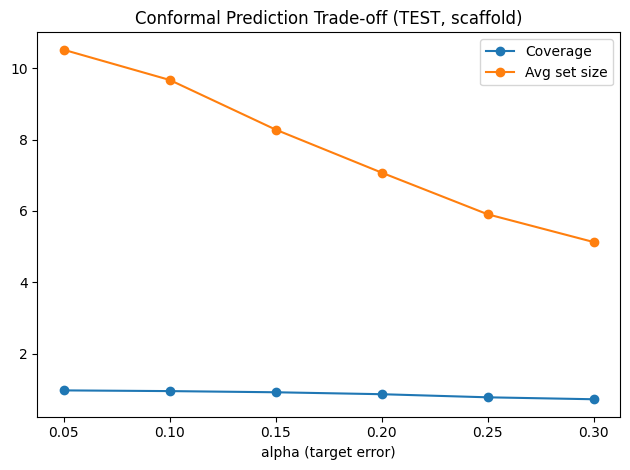

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

df_grid = pd.read_csv(RES/"cp_alpha_grid_test.csv")

plt.figure()
plt.plot(df_grid["alpha"], df_grid["coverage"], marker="o", label="Coverage")
plt.plot(df_grid["alpha"], df_grid["avg_set_size"], marker="o", label="Avg set size")
plt.xlabel("alpha (target error)")
plt.title("Conformal Prediction Trade-off (TEST, scaffold)")
plt.legend()
plt.tight_layout()
plt.savefig(PLOTS/"cp_tradeoff_alpha_grid.png", dpi=200)
print("Saved plot to", PLOTS/"cp_tradeoff_alpha_grid.png")


### 10c) Per-label bar chart at α = 0.15

Saved plot to tox21_chemberta_v5\plots\per_label_coverage_alpha0.15.png


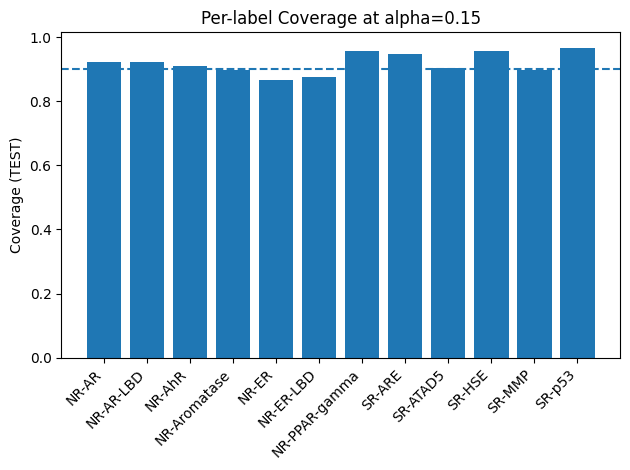

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

alpha_star = 0.15
df_star = pd.read_csv(RES/f"coverage_per_label_test_alpha{alpha_star:.2f}.csv")

plt.figure()
plt.bar(df_star["label"], df_star["coverage"])
plt.axhline(0.90, linestyle="--")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Coverage (TEST)")
plt.title(f"Per-label Coverage at alpha={alpha_star:.2f}")
plt.tight_layout()
plt.savefig(PLOTS/f"per_label_coverage_alpha{alpha_star:.2f}.png", dpi=200)
print("Saved plot to", PLOTS/f"per_label_coverage_alpha{alpha_star:.2f}.png")


## 11